In [19]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [20]:
def modelo_mma(x1, x2, u, m, b, k):
    """
    Função de estado do sistema Massa-Mola-Amortecedor (MMA).
    x1: posição, x2: velocidade, u: força de controle.
    """
    dx1 = x2
    dx2 = -(k/m)*x1 - (b/m)*x2 + (1/m)*u
    return np.array([dx1, dx2])

In [21]:
def funcao_custo(u_seq, x_atual, r_ref, Ts, Q, R, m, b, k, P):
    """
    Calcula o custo total da sequência de controle 'u_seq' no horizonte 'P'.
    J = sum_{n=0}^{P-1} [ Q1*(r - x1)^2 + Q2*x2^2 + R*u[n]^2 ]
    """
    x1h, x2h = x_atual[0], x_atual[1]  # Estados iniciais do horizonte
    J = 0
    
    for n in range(P):
        # Simulação do sistema (Euler Forward)
        dxh = modelo_mma(x1h, x2h, u_seq[n], m, b, k)
        x1h += Ts * dxh[0]
        x2h += Ts * dxh[1]

        J += Q[0] * (r_ref - x1h)**2 + Q[1] * x2h**2 + R * u_seq[n]**2

    return J

In [22]:
def controlador_mpc(x_atual, r_ref, u_seq_inicial, params, P):
    """
    Minimiza a Função Custo para encontrar a sequência de controle ótima.
    NÃO há restrições de limites ou variação de controle.
    """
    # Desempacotamento de parâmetros
    Ts, Q, R, m, b, k = params
    
    # Otimização: 
    resultado = minimize(funcao_custo, u_seq_inicial,
                         args = (x_atual, r_ref, Ts, Q, R, m, b, k, P))

    return resultado.x

In [23]:
# Parâmetros:
m, b, k = 1.0, 0.9, 0.8
Ts = 0.2 # Período de amostragem

# Configuração da Simulação
t_max = 20.0
N_sim = int(t_max / Ts) # Número total de passos
t = np.arange(0, t_max, Ts)

# Variáveis do Sistema
x1 = np.zeros(N_sim + 1) # Posição
x2 = np.zeros(N_sim + 1) # Velocidade
u = np.zeros(N_sim)      # Ação de controle
x = np.array([x1[0], x2[0]]) # Vetor de estado [x1, x2]

# Referência (Sinal degrau)
r = np.ones(N_sim) * 0
r[t>=5] = 2.0
r[t>=10] = -1.5
r[t>=15] = 0.5


# Parâmetros do MPC
P = 10                  # Horizonte de predição
Q = np.array([10.0, 0.2]) # Pesos: Q[0]  Q[1] 
R = 0.5                 # Peso para penalidade do controle (valor menor que o anterior, já que não há saturação)


In [24]:
# Inicialização do controle: Chute inicial
u0 = np.zeros(P)

# Vetor de parâmetros para o MPC
params = (Ts, Q, R, m, b, k)

for n in range(N_sim):
    # 1. Passo MPC: Encontra a sequência de controle ótima u_seq_otima
    r_ref = r[n] # Referência atual
    u_mpc = controlador_mpc(x, r_ref, u0, params, P)

    # 2. Aplica a primeira ação de controle (Estratégia Receding Horizon)
    u[n] = u_mpc[0]

    # 3. Simula o sistema com a ação de controle aplicada
    dx = modelo_mma(x[0], x[1], u[n], m, b, k)
    x[0] += Ts * dx[0]  # x1[n+1]
    x[1] += Ts * dx[1]  # x2[n+1]

    # Armazena e prepara para o próximo passo
    x1[n+1], x2[n+1] = x[0], x[1]
    u0 = u_mpc # Otimiza o chute inicial para a próxima iteração


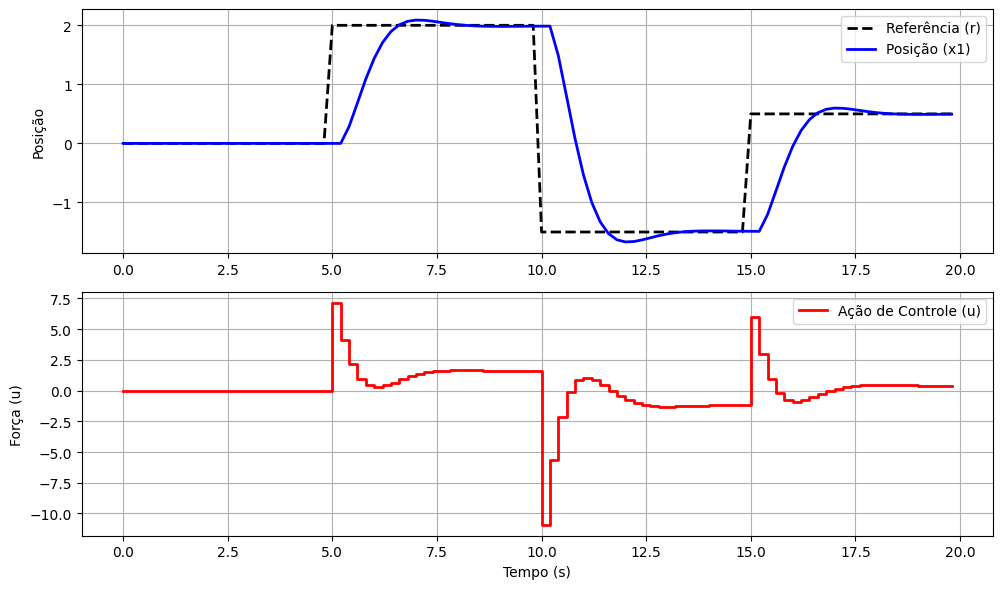

In [25]:
# --- 6. PLOTAGEM DOS RESULTADOS ---
plt.figure(figsize=(10, 6))

# Plot da Posição (Saída)
plt.subplot(2, 1, 1)
plt.plot(t, r, 'k--', linewidth=2, label='Referência (r)')
plt.plot(t, x1[:-1], 'b-', linewidth=2, label='Posição (x1)')
plt.ylabel('Posição')
plt.grid(True)
plt.legend()

# Plot do Sinal de Controle (Força)
plt.subplot(2, 1, 2)
plt.step(t, u, 'r-', where='post', linewidth=2, label='Ação de Controle (u)')
plt.ylabel('Força (u)')
plt.xlabel('Tempo (s)')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

In [26]:
for n in range(N_sim):
    r_ref = r[n]
    u_seq_otima = controlador_mpc(x, r_ref, u_seq_inicial, params, P)
    u[n] = u_seq_otima[0]

    # --- PLOTAGEM E ATUALIZAÇÃO DA FIGURA ---
    plt.clf() # Limpa a figura para desenhar a nova iteração

    # Subplot 1: Posição (Saída) e Referência
    plt.subplot(2, 1, 1)
    plt.plot(t, r, 'k--', linewidth=2, label='Referência (r)')
    plt.plot(t[:n+1], x1[:n+1], 'b-', linewidth=2, label='Posição (x1)')
    plt.title(f'Simulação MPC (Tempo: {t[n]:.1f} s)')
    plt.ylabel('Posição')
    plt.xlim(0, t_max)
    # ... (outros plt.xlim, plt.ylim, plt.grid, plt.legend)

    # Subplot 2: Sinal de Controle (u)
    plt.subplot(2, 1, 2)
    # Controle Aplicado
    plt.step(t[:n+1], u[:n+1], 'r-', where='post', linewidth=2, label='Controle Aplicado (u)')
    # Controle Predito (garante que os tamanhos de array sejam iguais no final da simulação)
    time_predicao = t[n:n+P]
    controle_predicao = u_seq_otima[:len(time_predicao)] 
    plt.plot(time_predicao, controle_predicao, 'g.', linestyle='--', label='Controle Predito', alpha=0.6)
    
    plt.ylabel('Força (u)')
    plt.xlabel('Tempo (s)')
    plt.xlim(0, t_max)
    # ... (outros plt.ylim, plt.grid, plt.legend)

    plt.tight_layout()
    # Em seu ambiente local, descomente as duas linhas abaixo:
    # plt.draw()    # Redesenha a tela
    # plt.pause(0.01) # Pausa por 0.01s para dar o efeito de animação

NameError: name 'u_seq_inicial' is not defined